<a href="https://colab.research.google.com/github/hamednaghavi89/Filter_repo/blob/master/timeseries_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,SimpleRNN,GRU,Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit



import warnings
warnings.filterwarnings('ignore')

In [2]:
#Method to plot the training metric vs validation mertric
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [3]:
data_path="lstm.xlsx"
data=pd.read_excel(data_path)
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'lstm.xlsx'

In [12]:
data.columns

Index(['Num', 'SigType', 'Open', 'High', 'Low', 'Close', 'Vol', 'Ind1_L',
       'Ind1_H', 'Ind2_Val', 'Ind2_AboveBelow', 'Ind3_ATR', 'Ind4_LN',
       'Ind4_SG', 'Ind4_Sign', 'Ind4_Diff', 'IsCross', 'LB-10', 'MA-10',
       'HB-10', 'LB-20', 'MA-20', 'HB-20', 'LB-50', 'MA-50', 'HB-50', 'SAR',
       'RSI-10', 'RSI-20', 'RSI-50', 'diff_MA10', 'diff_MA20', 'diff_MA50'],
      dtype='object')

In [13]:
target_name='diff_MA20'

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

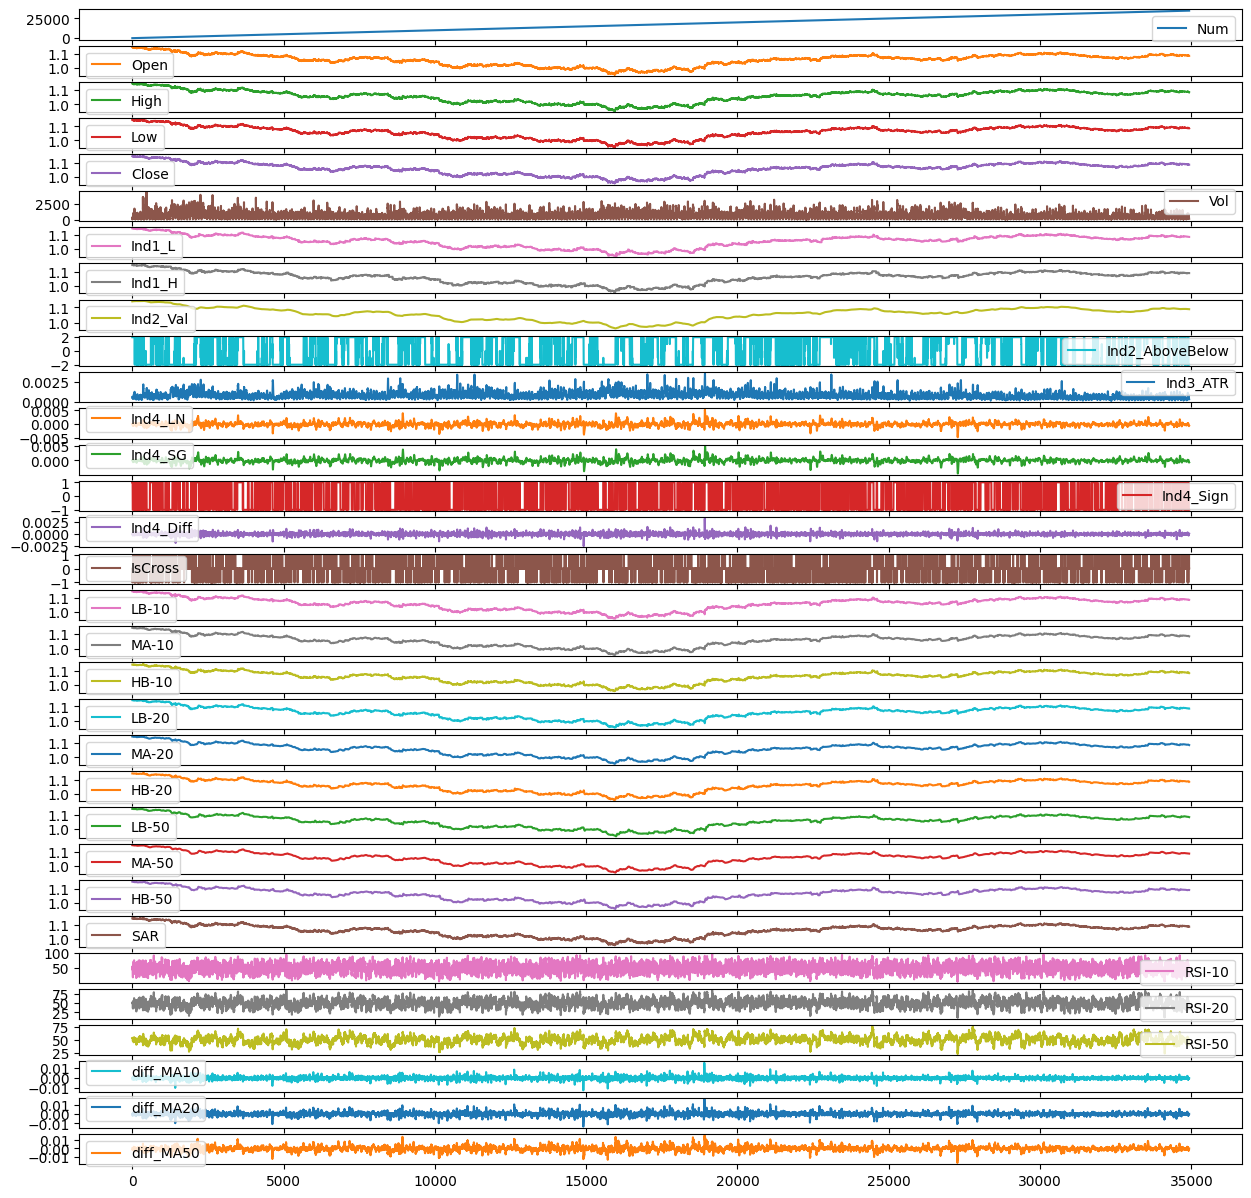

In [14]:
data.plot(subplots=True,figsize=(15,15))

<Axes: >

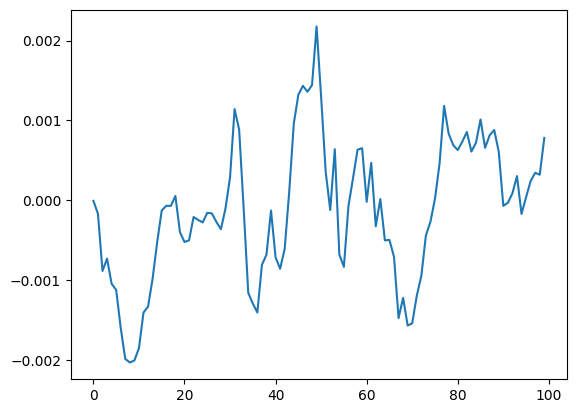

In [20]:
#--data[target_name].plot()
data[target_name][:100].plot()  #-- Only the first 100 elements

In [21]:
import statsmodels.api as sm

def is_data_random_walk(data):
    # Perform the ADF test
    result = sm.tsa.stattools.adfuller(data)

    # Extract the p-value from the test results
    p_value = result[1]

    # Compare the p-value with a significance level (e.g., 0.05)
    if p_value < 0.05:
        return "Data exhibits a random walk behavior. 🚶‍♂️"
    else:
        return "Data does not exhibit a random walk behavior. 🚶‍♀️"

# Test the function with your data
data_ = data[target_name]
result = is_data_random_walk(data_)
print(result)

Data exhibits a random walk behavior. 🚶‍♂️


In [23]:
x=data[target_name].values  #-- 'data' is DataFrame  +  'x' is ndarray

In [24]:

import numpy as np


inverse_x = np.flip(x)

#--x=(inverse_x)

In [25]:
import numpy as np

a = x

# Calculate the index to split the dataset
split_index = int(len(a) * 0.8)

# Split the dataset into training and testing sets
train_set = a[:split_index]
test_set = a[split_index:]

print("Training set:", train_set)
print("Testing set:", test_set)

Training set: [-7.5000e-06 -1.6950e-04 -8.8600e-04 ...  1.5255e-03  1.2070e-03
  1.4250e-03]
Testing set: [ 0.0005035 -0.0002125  0.000143  ...  0.         0.         0.       ]


In [26]:
#Prediction will take place on Adj Close price, therefore we must isolate Adj Close.
# trainprice = trainingData['Adj Close']
trainData = train_set

# testprice = testingData['Adj Close']
testData = test_set

In [27]:
sc = MinMaxScaler(feature_range=(0,1))
trainDataScaled = sc.fit_transform(trainData.reshape(-1, 1))
testDataScaled = sc.fit_transform(testData.reshape(-1, 1))

In [38]:

n_steps = 20  #--shn-- Our Lag ==> 20-inputs:1-output
              #--       ==> The output is diff(  MA20(10th_Later) - Close(10th_Later)  )

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])

xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))


In [39]:
#GRU Model

model = Sequential()

#Layer 1
model.add(GRU(units=200,return_sequences=True,input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
# #Layer 2
model.add(GRU(units=200,return_sequences=True))
model.add(Dropout(0.2))
# #Layer 3
model.add(GRU(units=200,return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 4
model.add(GRU(units=200, return_sequences=False))
# model.add(Dropout(0.2))
#Layer 5
model.add(Dense(units=200))
model.add(Dense(units=100))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

#Early stopping parameters to stop unnecessary training
earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    mode='min',
    min_delta = 0.000001
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 200)           121800    
                                                                 
 dropout (Dropout)           (None, 20, 200)           0         
                                                                 
 gru_1 (GRU)                 (None, 20, 200)           241200    
                                                                 
 dropout_1 (Dropout)         (None, 20, 200)           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 200)           241200    
                                                                 
 dropout_2 (Dropout)         (None, 20, 200)           0         
                                                                 
 gru_3 (GRU)                 (None, 20, 200)           2

In [23]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=256,
    validation_split = 0.25,
    verbose=1,
    callbacks=[earlyStopping],
    shuffle=False)
# plot_metric(log, 'root_mean_squared_error')

NameError: name 'model' is not defined

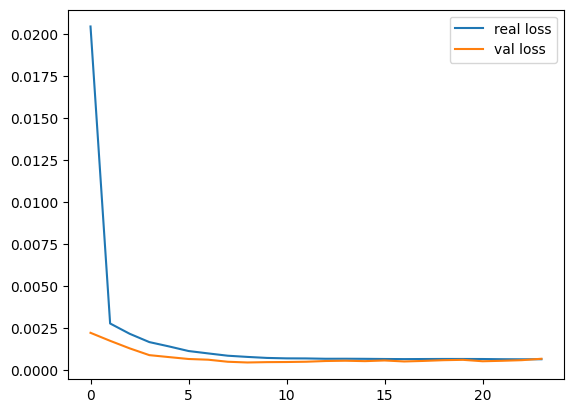

In [28]:
plt.plot(log.history['loss'],label="real loss")
plt.plot(log.history['val_loss'],label="val loss")
plt.legend()
plt.show()

In [29]:
n_steps = 20

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])

xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))



In [40]:
from sklearn.metrics import r2_score
predictions = model.predict(xTest)
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE


r2 = r2_score(predictions, yTest)
print("=============================================================================")
print("rmse=>",rmse)
print("r2_score=>",r2)

218/218 [==============================] - 60s 268ms/step
rmse=> 0.04399151424025956
r2_score=> 0.7297374104566559


In [42]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

218/218 [==============================] - 57s 261ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - mean_absolute_error: 0.0325


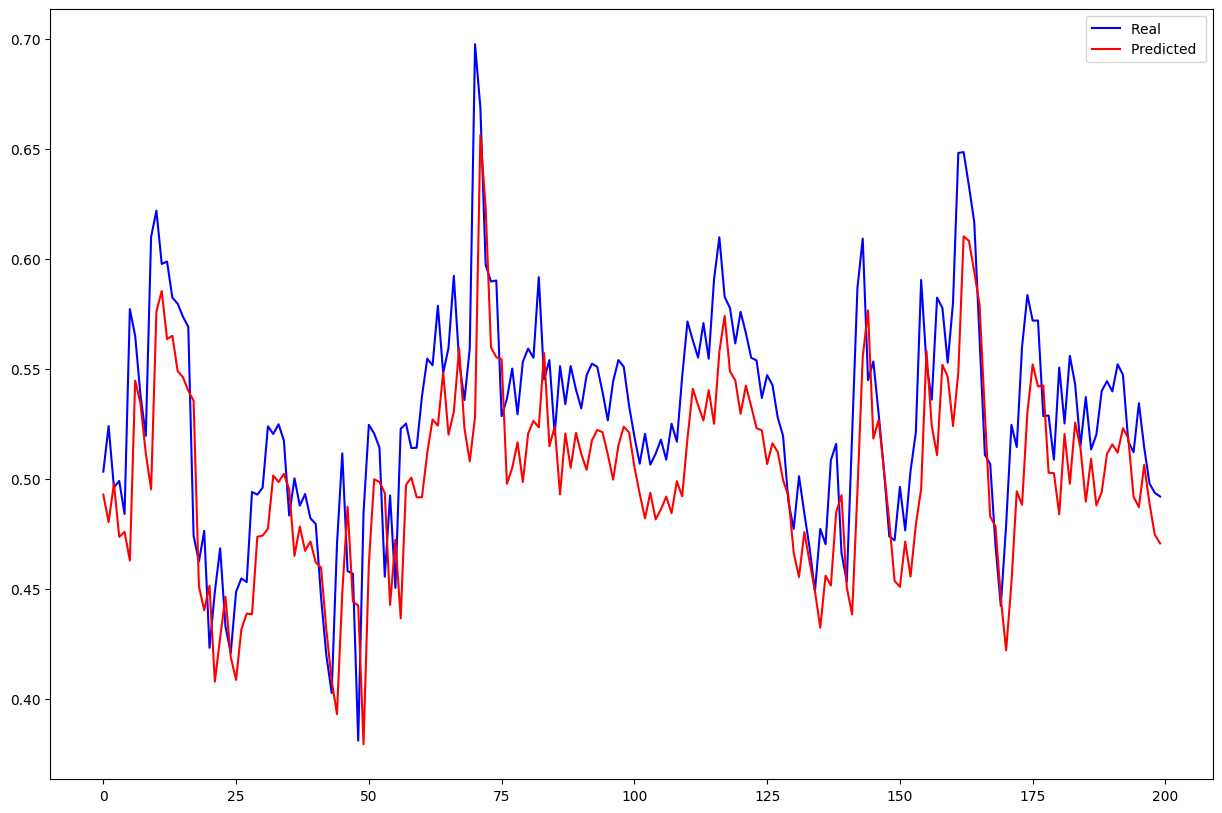

In [43]:
fig = plt.figure(figsize = (15,10))
plt.plot(yTest[:200], color='b', label='Real ')
plt.plot(predictions[:200], color='r', label='Predicted ')
plt.legend()

In [48]:
xTest[0]

array([[0.5369878 ],
       [0.47655821],
       [0.50656201],
       [0.51782926],
       [0.60070895],
       [0.57344812],
       [0.56285606],
       [0.55538676],
       [0.53546862],
       [0.53703   ],
       [0.56171667],
       [0.57066295],
       [0.53833819],
       [0.48069376],
       [0.4774866 ],
       [0.53179727],
       [0.52517196],
       [0.51550829],
       [0.56209647],
       [0.51804026]])

In [49]:
xTest[0].shape

(20, 1)

In [50]:
type(xTest[0])

numpy.ndarray

In [51]:
from keras.models import load_model
# Save the model to a file
model.save('my_model.h5')

# Reload the model from the file
loaded_model = load_model('my_model.h5')

# Use the reloaded model for prediction
# preds = loaded_model.predict(data)